# Estimating prediction intervals of time series forecast with EnbPI

This example uses `mapie.time_series_regression.MapieTimeSeriesRegressor` to estimate
prediction intervals associated with time series forecast. It follows Xu \& Xie (2021).
We use here the Victoria electricity demand dataset used in the book
"Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos.
The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable.
A Random Forest model is already fitted on data. The hyper-parameters are
optimized with a `sklearn.model_selection.RandomizedSearchCV` using a
sequential `sklearn.model_selection.TimeSeriesSplit` cross validation,
in which the training set is prior to the validation set.
The best model is then feeded into
`mapie.time_series_regression.MapieTimeSeriesRegressor` to estimate the
associated prediction intervals. We compare four approaches: with or without
``partial_fit`` called at every step.

In [1]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.subsample import BlockBootstrap
from mapie.time_series_regression import MapieTimeSeriesRegressor

%reload_ext autoreload
%autoreload 2
warnings.simplefilter("ignore")

## 1. Load input data and feature engineering

In [2]:
file_path = './data/metr-la.h5'
data = pd.read_hdf(file_path,)

In [3]:
data.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875
2012-03-01 00:10:00,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500,64.250,63.875000,65.375000,...,44.125000,69.000,56.500000,59.250000,68.125,62.500000,65.625000,61.375000,69.857143,62.000
2012-03-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
2012-03-01 00:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000


In [4]:
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %H:%M:%S', )

In [5]:
column_data = data['773869'].values

In [6]:
column_data

array([64.375     , 62.66666667, 64.        , ..., 67.        ,
       66.75      , 65.11111111])

In [7]:
# Create a datetime index (you can customize the date range as needed)
date_index = pd.date_range(start='2012-03-01', periods=len(column_data), freq='5T')

# Create a DataFrame with the data and index
df = pd.DataFrame(column_data, columns=['flow'], index=date_index)



In [17]:
data.tail()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-06-27 23:35:00,65.000000,65.888889,68.555556,61.666667,0.0,54.555556,62.444444,63.333333,59.222222,65.333333,...,52.888889,69.000000,65.111111,55.666667,66.333333,62.444444,66.777778,64.888889,69.666667,62.333333
2012-06-27 23:40:00,61.375000,65.625000,66.500000,62.750000,0.0,50.500000,62.000000,67.000000,65.250000,67.125000,...,54.000000,69.250000,60.125000,60.500000,67.250000,59.375000,66.000000,61.250000,69.000000,62.000000
2012-06-27 23:45:00,67.000000,59.666667,69.555556,61.000000,0.0,44.777778,64.222222,63.777778,59.777778,57.666667,...,51.333333,67.888889,64.333333,57.000000,66.000000,62.666667,68.666667,63.333333,67.444444,61.222222
2012-06-27 23:50:00,66.750000,62.250000,66.000000,59.625000,0.0,53.000000,64.285714,64.125000,60.875000,66.250000,...,51.125000,69.375000,61.625000,60.500000,65.625000,66.375000,69.500000,63.000000,67.875000,63.500000
2012-06-27 23:55:00,65.111111,66.888889,66.777778,61.222222,0.0,49.555556,65.777778,65.111111,63.000000,61.666667,...,56.000000,67.444444,64.888889,60.888889,64.222222,66.444444,68.444444,63.555556,68.666667,61.777778


In [18]:
len(data)

34272

In [37]:
def generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets, add_time_in_day=False, add_day_in_week=False, scaler=None
):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param add_time_in_day:
    :param add_day_in_week:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    data = np.expand_dims(df.values, axis=-1)
    data_list = [data]
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
        data_list.append(time_in_day)
    if add_day_in_week:
        day_in_week = np.zeros(shape=(num_samples, num_nodes, 7))
        day_in_week[np.arange(num_samples), :, df.index.dayofweek] = 1
        data_list.append(day_in_week)

    data = np.concatenate(data_list, axis=-1)
    # epoch_len = num_samples + min(x_offsets) - max(y_offsets)
    x, y = [], []
    # t is the index of the last observation.
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        y_t = data[t + y_offsets, ...]
        x.append(x_t)
        y.append(y_t)
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    return x, y


def generate_train_val_test(args):
    df = pd.read_hdf(args)
    # 0 is the latest observed sample.
    x_offsets = np.sort(
        # np.concatenate(([-week_size + 1, -day_size + 1], np.arange(-11, 1, 1)))
        np.concatenate((np.arange(-11, 1, 1),))
    )
    # Predict the next one hour
    y_offsets = np.sort(np.arange(1, 13, 1))
    # x: (num_samples, input_length, num_nodes, input_dim)
    # y: (num_samples, output_length, num_nodes, output_dim)
    x, y = generate_graph_seq2seq_io_data(
        df,
        x_offsets=x_offsets,
        y_offsets=y_offsets,
        add_time_in_day=False,
        add_day_in_week=False,
    )

    print("x shape: ", x.shape, ", y shape: ", y.shape)
    # Write the data into npz file.
    # num_test = 6831, using the last 6831 examples as testing.
    # for the rest: 7/8 is used for training, and 1/8 is used for validation.
    num_samples = x.shape[0]
    num_test = round(num_samples * 0.2)
    num_train = round(num_samples * 0.7)
    num_val = num_samples - num_test - num_train

    # train
    x_train, y_train = x[:num_train], y[:num_train]
    # val
    x_val, y_val = (
        x[num_train: num_train + num_val],
        y[num_train: num_train + num_val],
    )
    # test
    x_test, y_test = x[-num_test:], y[-num_test:]

    return x_train, y_train, x_val, y_val, x_test, y_test

In [38]:
x_train, y_train, x_val, y_val, x_test, y_test = generate_train_val_test(file_path)

x shape:  (34249, 12, 207, 1) , y shape:  (34249, 12, 207, 1)


In [36]:
x_train[0][2][0]

array([6.40000000e+01, 6.94444444e-03])

In [31]:
y_train.shape

(23974, 12, 207, 2)

<Axes: >

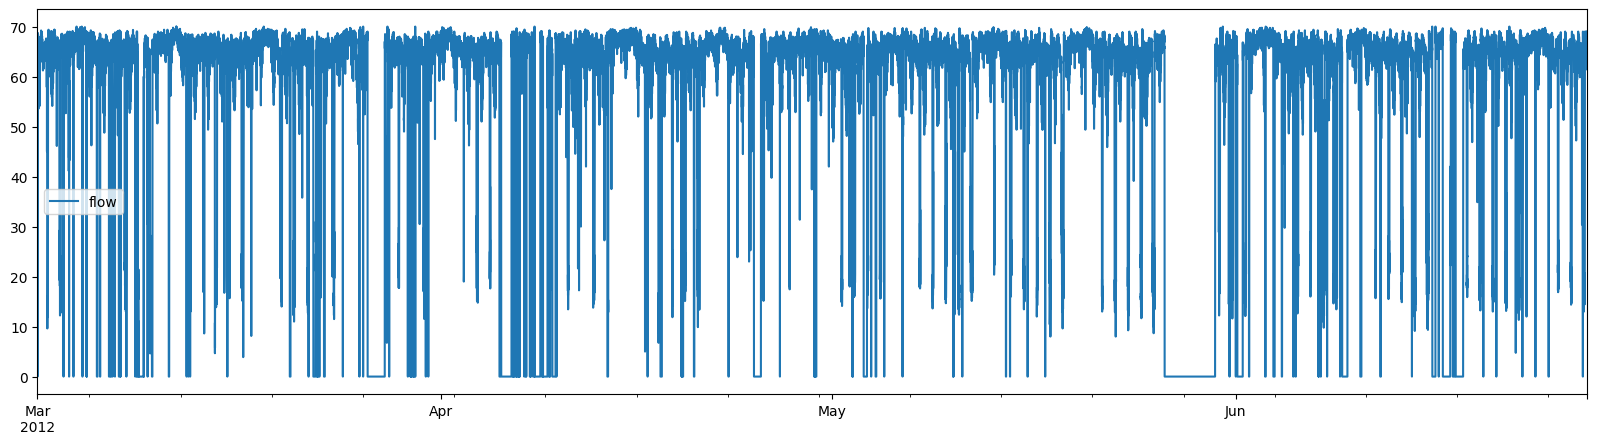

In [8]:
df.plot(figsize =(20,5))

In [9]:
demand_df = df.copy()
demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["flow"].shift(hour)


In [10]:
demand_df

,flow,Date,Weekofyear,Weekday,Hour,Lag_1,Lag_2,Lag_3,Lag_4
2012-03-01 00:00:00,64.375000,2012-03-01 00:00:00,9,4,0,NaN,NaN,NaN,NaN
2012-03-01 00:05:00,62.666667,2012-03-01 00:05:00,9,4,0,64.375000,NaN,NaN,NaN
2012-03-01 00:10:00,64.000000,2012-03-01 00:10:00,9,4,0,62.666667,64.375000,NaN,NaN
2012-03-01 00:15:00,0.000000,2012-03-01 00:15:00,9,4,0,64.000000,62.666667,64.375000,NaN
2012-03-01 00:20:00,0.000000,2012-03-01 00:20:00,9,4,0,0.000000,64.000000,62.666667,64.375000
...,...,...,...,...,...,...,...,...,...
2012-06-27 23:35:00,65.000000,2012-06-27 23:35:00,26,3,23,62.875000,67.625000,63.111111,67.428571
2012-06-27 23:40:00,61.375000,2012-06-27 23:40:00,26,3,23,65.000000,62.875000,67.625000,63.111111
2012-06-27 23:45:00,67.000000,2012-06-27 23:45:00,26,3,23,61.375000,65.000000,62.875000,67.625000
2012-06-27 23:50:00,66.750000,2012-06-27 23:50:00,26,3,23,67.000000,61.375000,65.000000,62.875000


## 2. Train/validation/test split

In [11]:
num_test_steps = 24 * 12 * 7
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Weekofyear", "Weekday", "Hour"]
features += [f"Lag_{hour}" for hour in range(1, n_lags)]

X_train = demand_train.loc[
    ~np.any(demand_train[features].isnull(), axis=1), features
]
y_train = demand_train.loc[X_train.index, "flow"]
X_test = demand_test.loc[:, features]
y_test = demand_test["flow"]

In [12]:
X_train

,Weekofyear,Weekday,Hour,Lag_1,Lag_2,Lag_3,Lag_4
2012-03-01 00:20:00,9,4,0,0.000000,64.000000,62.666667,64.375000
2012-03-01 00:25:00,9,4,0,0.000000,0.000000,64.000000,62.666667
2012-03-01 00:30:00,9,4,0,57.333333,0.000000,0.000000,64.000000
2012-03-01 00:35:00,9,4,0,66.500000,57.333333,0.000000,0.000000
2012-03-01 00:40:00,9,4,0,63.625000,66.500000,57.333333,0.000000
...,...,...,...,...,...,...,...
2012-06-20 23:35:00,25,3,23,63.500000,65.000000,63.875000,66.333333
2012-06-20 23:40:00,25,3,23,64.875000,63.500000,65.000000,63.875000
2012-06-20 23:45:00,25,3,23,60.333333,64.875000,63.500000,65.000000
2012-06-20 23:50:00,25,3,23,67.000000,60.333333,64.875000,63.500000


Text(0, 0.5, 'Hourly demand (GW)')

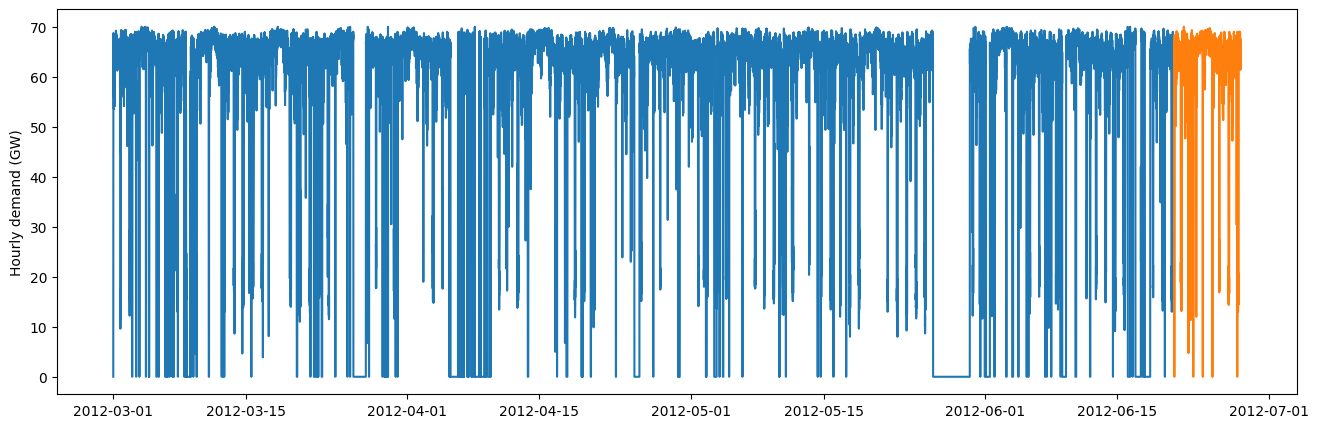

In [13]:
plt.figure(figsize=(16, 5))
plt.plot(y_train)
plt.plot(y_test)
plt.ylabel("Hourly demand (GW)")

## 3. Optimize the base estimator

In [14]:
model_params_fit_not_done = True
if model_params_fit_not_done:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59)

## 4. Estimate prediction intervals on the test set

In [15]:
alpha = 0.05
gap = 1
cv_mapiets = BlockBootstrap(
    n_resamplings=100, length=48, overlapping=True, random_state=59
)
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

### Without partial fit

In [66]:
print("EnbPI, with no partial_fit, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

EnbPI, with no partial_fit, width optimization


In [17]:
np.shape(y_pis_npfit)

(2016, 2, 1)

In [18]:
y_pis_npfit

array([[[56.47882589],
        [70.6400361 ]],

       [[54.9981741 ],
        [69.1593843 ]],

       [[55.45541213],
        [69.61662234]],

       ...,

       [[53.09224423],
        [67.25345444]],

       [[55.27426091],
        [69.43547112]],

       [[55.47247366],
        [69.63368387]]])

### With partial fit

In [67]:
print("EnbPI with partial_fit, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

EnbPI with partial_fit, width optimization


## V. Plot estimated prediction intervals on test set

In [68]:
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

In [21]:
np.shape(y_pis)

(2, 2016, 2, 1)

In [30]:
y_test.index[: 288]

DatetimeIndex(['2012-06-21 00:00:00', '2012-06-21 00:05:00',
               '2012-06-21 00:10:00', '2012-06-21 00:15:00',
               '2012-06-21 00:20:00', '2012-06-21 00:25:00',
               '2012-06-21 00:30:00', '2012-06-21 00:35:00',
               '2012-06-21 00:40:00', '2012-06-21 00:45:00',
               ...
               '2012-06-21 23:10:00', '2012-06-21 23:15:00',
               '2012-06-21 23:20:00', '2012-06-21 23:25:00',
               '2012-06-21 23:30:00', '2012-06-21 23:35:00',
               '2012-06-21 23:40:00', '2012-06-21 23:45:00',
               '2012-06-21 23:50:00', '2012-06-21 23:55:00'],
              dtype='datetime64[ns]', length=288, freq='5T')

In [35]:
def plot_forecast(y_train, y_test, y_preds, y_pis, coverages, widths, plot_coverage=True):
    fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
    )
    for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
        ax.set_ylabel("Hourly demand (GW)")
        # ax.plot(y_train[int(-len(y_test)/2):], lw=2, label="Training data", c="C0")
        ax.plot(y_test[: 50], lw=2, label="Test data", c="C1")

        ax.plot(
            y_test.index[: 50], y_preds[i][: 50], lw=2, c="C2", label="Predictions"
        )
        ax.fill_between(
            y_test.index[: 50],
            y_pis[i][:50, 0, 0],
            y_pis[i][:50, 1, 0],
            color="C2",
            alpha=0.2,
            label="Prediction intervals",
        )
        title = f"EnbPI, {w} update of residuals. "
        if plot_coverage:
            title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
        ax.set_title(title)
        ax.legend()
    fig.tight_layout()
    plt.show()

In [64]:
def plot_forecast(y_train, y_test, y_preds, y_pis, coverages, widths, plot_coverage=True):
    fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
    )
    for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
        ax.set_ylabel("Hourly demand (GW)")
        # ax.plot(y_train[int(-len(y_test)/2):], lw=2, label="Training data", c="C0")
        ax.plot(y_test, lw=2, label="Test data", c="C1")

        ax.plot(
            y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
        )
        ax.fill_between(
            y_test.index,
            y_pis[i][:, 0, 0],
            y_pis[i][:, 1, 0],
            color="C2",
            alpha=0.2,
            label="Prediction intervals",
        )
        title = f"EnbPI, {w} update of residuals. "
        if plot_coverage:
            title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
        ax.set_title(title)
        ax.legend()
    fig.tight_layout()
    plt.show()

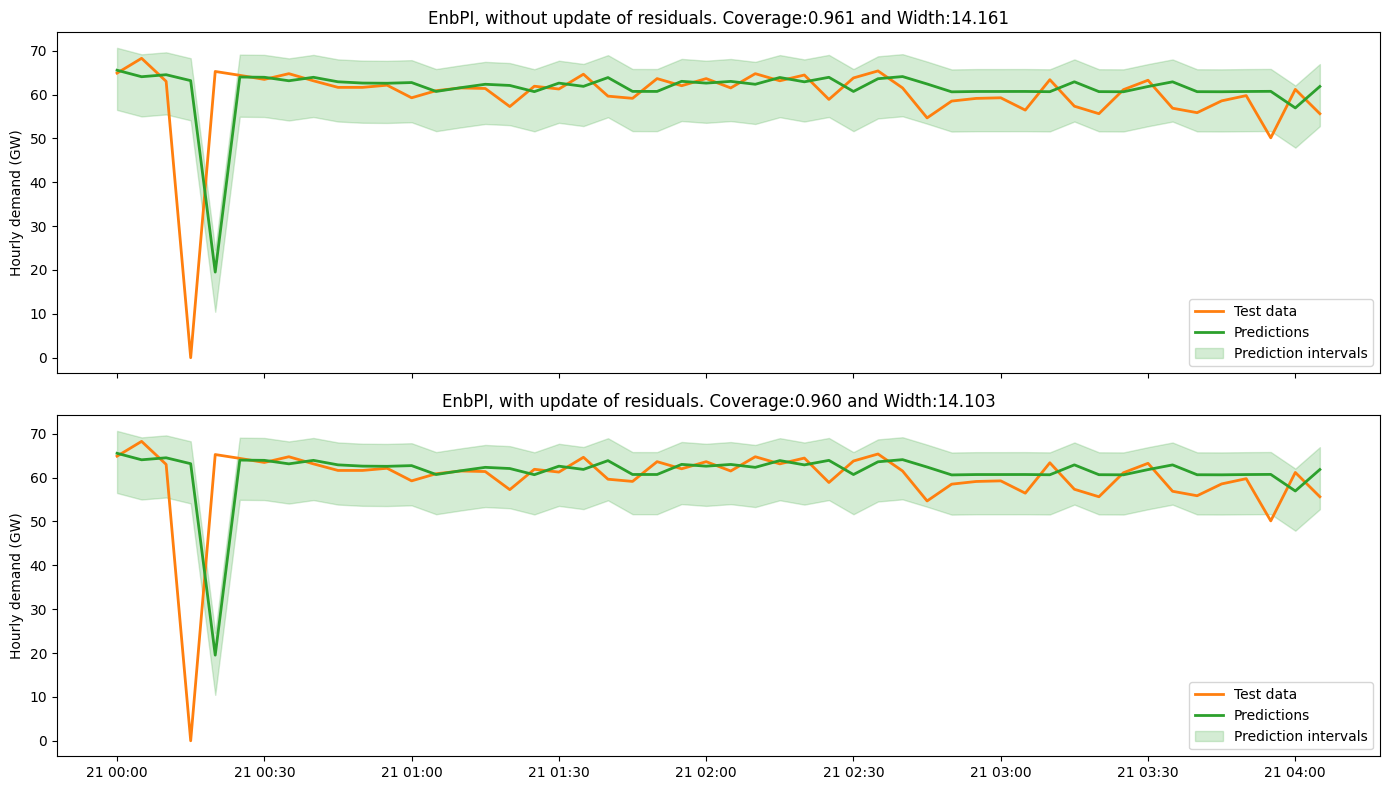

In [36]:
plot_forecast(y_train, y_test, y_preds, y_pis, coverages, widths)

## VI. Forecast on test dataset with change point

We will now see how MAPIE adapts its prediction intervals when a brutal changepoint arises in the test set. To simulate this, we will artificially decrease the electricity demand by 2 GW in the test set, aiming at simulating an effect, such as blackout or lockdown due to a pandemic, that was not taken into account by the model during its training. 

### Corrupt the dataset

In [54]:
demand_df_corrupted = demand_df.copy()
demand_df_corrupted.flow.iloc[-int(num_test_steps/2):] -= 10

In [55]:
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["flow"].shift(hour)
demand_train_corrupted = demand_df_corrupted.iloc[:-num_test_steps, :].copy()
demand_test_corrupted = demand_df_corrupted.iloc[-num_test_steps:, :].copy()

X_train = demand_train_corrupted.loc[
    ~np.any(demand_train_corrupted[features].isnull(), axis=1), features
]
y_train = demand_train_corrupted.loc[X_train.index, "flow"]
X_test = demand_test_corrupted.loc[:, features]
y_test = demand_test_corrupted["flow"]

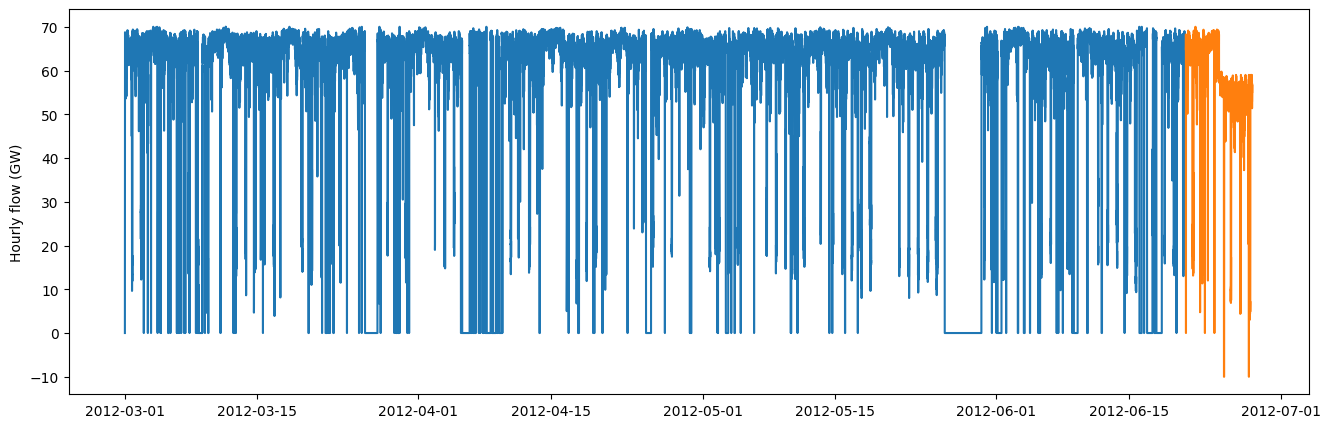

In [56]:
plt.figure(figsize=(16, 5))
plt.ylabel("Hourly flow (GW)")
plt.plot(y_train)
plt.plot(y_test)

### Prediction intervals without partial fit

In [57]:
print("EnbPI, with no partial_fit, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

EnbPI, with no partial_fit, width optimization


### Prediction intervals with partial fit

In [58]:
print("EnbPI with partial_fit, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit, lower_quantiles_pfit, higher_quantiles_pfit = [], [], []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True, 
        optimize_beta=True
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

EnbPI with partial_fit, width optimization


### Plot estimated prediction intervals on test set

In [59]:
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

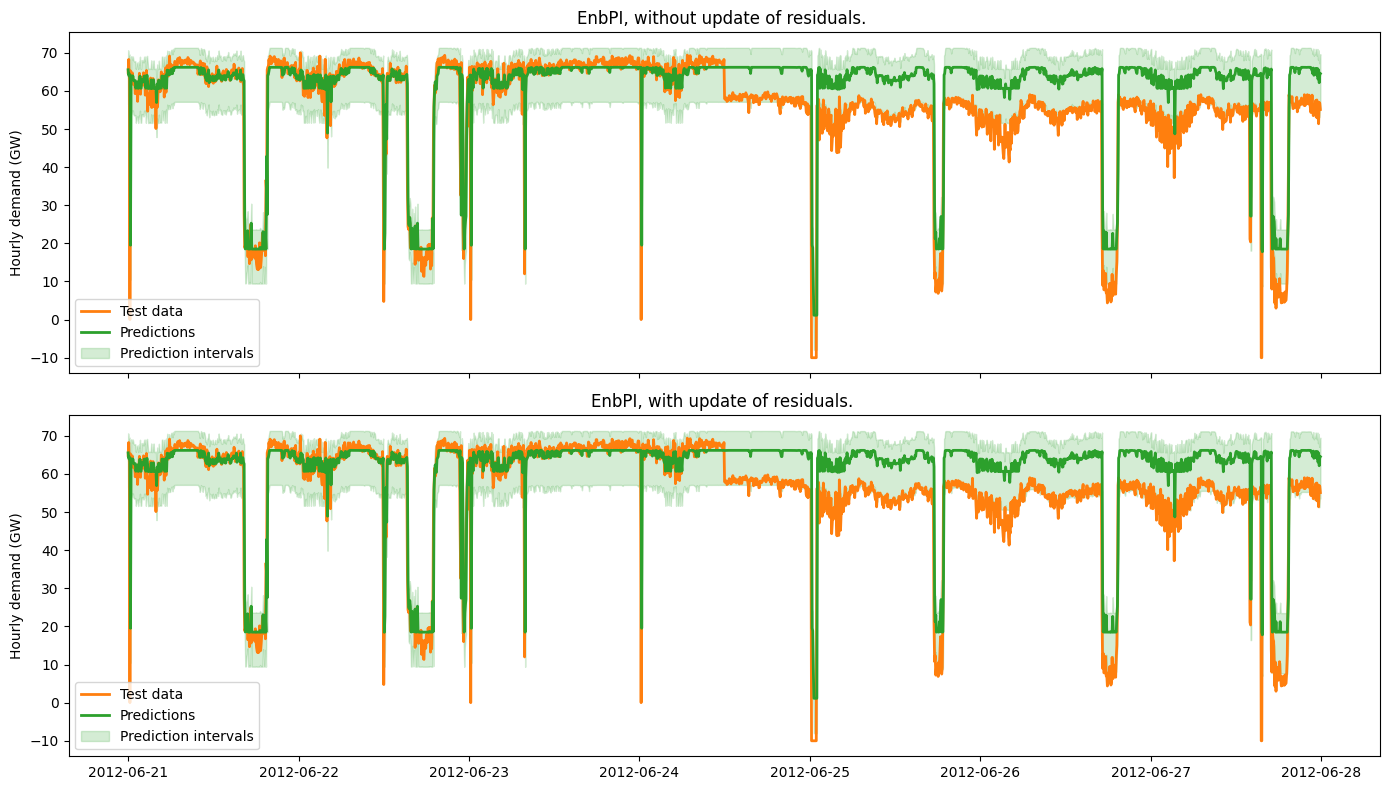

In [65]:
plot_forecast(y_train, y_test, y_preds, y_pis, coverages, widths, plot_coverage=False)

In [61]:
window = 24*12
rolling_coverage_pfit, rolling_coverage_npfit = [], []
for i in range(window, len(y_test), 1):
    rolling_coverage_pfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_pfit[i-window:i, 0, 0], y_pis_pfit[i-window:i, 1, 0]
        )
    )
    rolling_coverage_npfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_npfit[i-window:i, 0, 0], y_pis_npfit[i-window:i, 1, 0]
        )
    )

### Marginal coverage on a 24-hour rolling window of prediction intervals

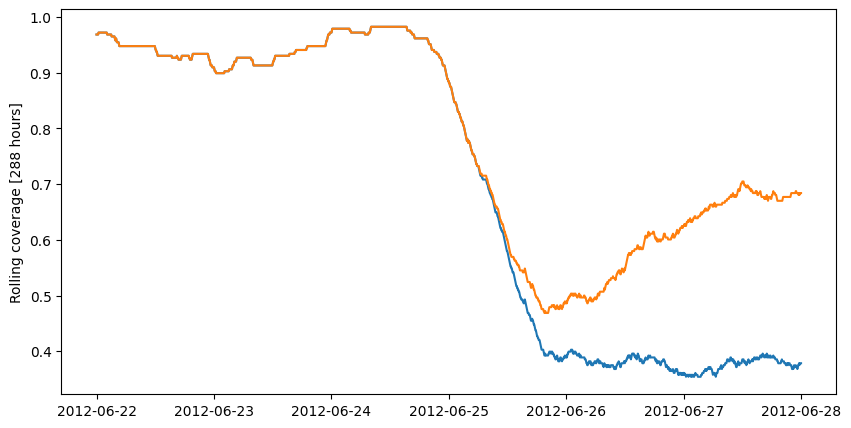

In [62]:
plt.figure(figsize=(10, 5))
plt.ylabel(f"Rolling coverage [{window} hours]")
plt.plot(y_test[window:].index, rolling_coverage_npfit, label="Without update of residuals")
plt.plot(y_test[window:].index, rolling_coverage_pfit, label="With update of residuals")

### Temporal evolution of the distribution of residuals used for estimating prediction intervals

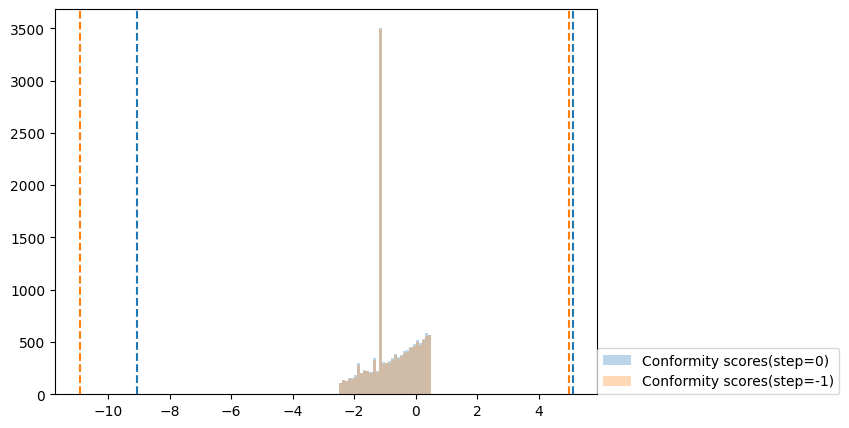

In [63]:
plt.figure(figsize=(7, 5))
for i, j in enumerate([0, -1]):
    plt.hist(conformity_scores_pfit[j], range=[-2.5, 0.5], bins=30, color=f"C{i}", alpha=0.3, label=f"Conformity scores(step={j})")
    plt.axvline(lower_quantiles_pfit[j], ls="--", color=f"C{i}")
    plt.axvline(higher_quantiles_pfit[j], ls="--", color=f"C{i}")
plt.legend(loc=[1, 0])